# Model Analysis

In the previous chapter, we introduced the basic use of `PyTorch` and use a neural network model to predict the probabilities of listed firms' tax non-compliance behaviors. Our previous model may be too simple, this leads to a bad prediction performance. By tunning the hyperparameters or regularizaition, we can further improve our model.

So in this chapter, we would first introduce some regularization methods including $\ell_2$ regularization, dropout, early stopping and batch normalization. Then, we apply these methods to the example of tax non-compliant firms classfication.

**Learning Goal**:
1. Implementing some regularization methods (L2 penalty, dropout, early stopping);
2. Implementing batch normalization;

## Contents

## 0 - Import Packages and Data

In [2]:
import pandas as pd # used for data import
import numpy as np # used for numerical operations
import torch # used for tensor operations
import torch.nn as nn # used for building neural networks
from torch.utils.data import DataLoader, TensorDataset # used for creating data loaders
from sklearn.preprocessing import StandardScaler # used for standardizing features
from sklearn.metrics import precision_recall_curve, average_precision_score # used for evaluating models
import statsmodels.api as sm # used for probit & logit regression
import matplotlib.pyplot as plt # used for plotting PR curves
from sklearn.model_selection import train_test_split # used for splitting data into train/valiadtion sets

from utils import FNN, train, test

np.random.seed(42) # set random seed for reproducibility
torch.manual_seed(42)

In [ ]:
train_df = pd.read_csv('../全连接神经网络/train_data.csv') # import training data
test_df = pd.read_csv('../全连接神经网络/test_data.csv')

train_df, valid_df = train_test_split(train_df, 
                                      stratify=train_df['noncompliance'], 
                                      test_size=0.2, 
                                      random_state=42,
                                      shuffle=True)

scaler = StandardScaler()
X_train_array = scaler.fit_transform(train_df.drop(['noncompliance'], axis=1))
X_valid_array = scaler.transform(valid_df.drop(['noncompliance'], axis=1))
X_test_array = scaler.transform(test_df.drop(['noncompliance'], axis=1))
y_train_array = train_df['noncompliance'].values
y_valid_array = valid_df['noncompliance'].values
y_test_array = test_df['noncompliance'].values

def prepare_loader(X_array, y_array, batch_size, shuffle):
    """
    transform array like data into DataLoader
    params:
        X_array: ndarray, feature;
        y_array: ndarray, label;
        batch_size: int, batch size;
        shuffle: bool, change the order of samples;
    return:
        loader: DataLoader, data including features and labels used in pytorch.
    """
    X_tensor = torch.tensor(X_array, dtype=torch.float32)
    y_tensor = torch.tensor(y_array, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

train_loader = prepare_loader(X_train_array, y_train_array, batch_size=128, shuffle=True)
valid_loader = prepare_loader(X_valid_array, y_valid_array, batch_size=128, shuffle=True)
test_loader = prepare_loader(X_test_array, y_test_array, batch_size=128, shuffle=False)

## 1 - $\ell_2$ Regularization

Recall the backpropagation of $\ell_2$ penalty:
$J_2 = \frac{\lambda}{2n} \sum_{l} ||W^{[l]}||_{F}^2$ 
and the derivative is 
$\frac{\partial J_2}{\partial W^{[l]}} = \frac{\lambda}{n} W^{[l]}.$
The update step for $\ell_2$ penalty is 
$$
W^{[l] (t+1)} = W^{[l] (t)} - \text{lr} \times (\text{grad}_{W^{[l]}} + \lambda \times W^{[l] (t)}).
$$

**In the optimizer without momentum** (e.g. `torch.optim.SGD`), we can implement $\ell_2$ regularization by adding $\lambda \times W$ to the gradients, instead of actually modifying the loss function. This can be done by setting the param `weight_decay`, which allows the optimizer to update parameters in the following way: 
$$
\text{param} = \text{param} - \text{lr} \times (\text{grad} + \text{weight decay} * \text{param})
$$

**In the optimizer with momentum** (e.g. `torch.optim.Adam`), `weight_decay` and $\ell_2$ regularization are different, see [Loshchilov and Hutter (2019)](https://arxiv.org/pdf/1711.05101) for more details. The solution is to use `torch.optim.AdamW` optimizer. 

In the following codes, we 
1. assign all the weight parameters to a list `decay`, and assign all the bias parameters to  `no_decay`; 
2. set `weight_decay` to be 3e-3 for weight parameters, and 0 for bias parameters.


In [ ]:
model = FNN()
criterion = nn.BCELoss()

decay, no_decay = [], []
for name, param in model.named_parameters():
    if 'bias' in name or 'bn' in name:  # exclude bias and batch norm parameters from weight decay
        no_decay.append(param)
    else: # all other parameters (weights) will have weight decay
        decay.append(param)

optimizer = torch.optim.AdamW([
    {'params': decay, 'weight_decay': 3e-3}, # set weight decay for weights
    {'params': no_decay, 'weight_decay': 0.0} # set no weight decay for bias
], lr=3e-4)

In [ ]:
train(model, train_loader, criterion, optimizer, num_epochs=500)

In [ ]:
def l2_norm_all_weights(model):
    total_norm = 0.0
    for name, param in model.named_parameters():
        if 'weight' in name and param.requires_grad:
            total_norm += torch.norm(param, p=2) ** 2
    return total_norm.sqrt()

l2_norm_all_weights(model) # check the l2 norm of all weights

In [ ]:
nn_l2_pred_probs = test(model, test_loader, criterion)
average_precision_score(y_test_array, nn_l2_pred_probs)

## 2 - Dropout

In the following codes, we build a network with dropout.

In the `__init__` method, `self.dropout1 = nn.Dropout(p=0.5)` defines a dropout layer with dropout probability of 0.5, it would randomly zeroes some elements of the input with probability $p=0.5$ during training mode.

In the `forward` method, `x = self.dropout1(x)` applies the dropout operator to the output of first layer.

In [ ]:
class FNN_dropout(nn.Module):
    """
    A fully connected neural network with dropout.
    """
    def __init__(self):
        super(FNN_dropout, self).__init__()
        self.fc1 = nn.Linear(24, 64)
        self.dropout1 = nn.Dropout(p=0.5) # define dropout layer with 50% probability
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(p=0.3) # define dropout layer with 30% probability
        self.fc3 = nn.Linear(32, 8)
        self.dropout3 = nn.Dropout(p=0.1) # define dropout layer with 10% probability
        self.fc4 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x) # apply dropout
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x) # apply dropout
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x) # apply dropout
        x = torch.sigmoid(self.fc4(x))
        return x
    

In [ ]:
model_dropout = FNN_dropout()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=3e-4)
train(model_dropout, train_loader, criterion, optimizer, num_epochs=500)

In [ ]:
nn_dropout_pred_probs = test(model_dropout, test_loader, criterion)
average_precision_score(y_test_array, nn_dropout_pred_probs) # 0.3123840521753748

## 3 - Early Stopping

The implementation of early stopping is easy, so in the following codes, we define a `EarlyStopping` class by hand.

In [4]:
class EarlyStopping:
    '''Early stops training if validation loss doesnt imporve after patience'''
    def __init__(self, patience=50, delta=0, path='checkpoint.pt', verbose=False):
        '''
        params:
            patience: int, number of epochs to wait since no improvement
            delta: float, validation loss change to detect siginificant improvement
            path: path to save the checkpoint
        '''
        self.patience = patience
        self.delta = delta
        self.save_path = path
        self.counter = 0
        self.early_stop = False
        self.best_valid_loss = None
        self.valid_loss_min = np.Inf
        self.verbose = verbose
        self.path = path
    
    def __call__(self, valid_loss, model):
        if self.best_valid_loss is None:
            self.best_valid_loss = valid_loss
            self.save_checkpoint(valid_loss, model)
        elif valid_loss < self.best_valid_loss - self.delta:
            # significant improvement detect
            self.best_valid_loss = valid_loss
            self.save_checkpoint(valid_loss, model)
            self.counter = 0 # reset counter since improvement
            
        else:
            # no significant improvement
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, valid_loss, model):
        '''save models when validation loss decreases'''
        if self.verbose:
            print(f'validation loss decrease: {self.valid_loss_min:.6f} -> {valid_loss:.6f}. Saving model.')
        torch.save(model.state_dict(), self.path)
        self.valid_loss_min = valid_loss

In [5]:
def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs):
    train_losses, valid_losses = [], []
    early_stopping = EarlyStopping() # initialize an EarlyStopping object

    for epoch in range(num_epochs):
        # train the model
        model.train()
        acc_train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad() # clear previous gradients
            output = model(data) # forward propagation
            loss = criterion(output.squeeze(1), target) # calculate average batch loss
            loss.backward() # backpropagation
            optimizer.step() # update parameters
            acc_train_loss += loss.item() * data.size(0) # accumulate loss
        train_loss = acc_train_loss / len(train_loader.dataset) # calculate average epoch loss
        train_losses.append(train_loss)
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {train_loss:.4f}")

        # validate the model
        model.eval()
        acc_valid_loss = 0
        for data, target in valid_loader:
            output = model(data)
            loss = criterion(output.squeeze(1), target)
            acc_valid_loss += loss.item() * data.size(0)
        valid_loss = acc_valid_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)
        # early stopping
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print('early stopping.')
            break
    model.load_state_dict(torch.load('checkpoint.pt', weights_only=True))
    return model, train_losses, valid_losses
    

In [7]:
model = FNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model, train_losses, valid_losses = train_and_validate(model, train_loader, valid_loader, criterion, optimizer, 500)

Epoch [50/500] Loss: 0.1573
Epoch [100/500] Loss: 0.1438
early stopping.


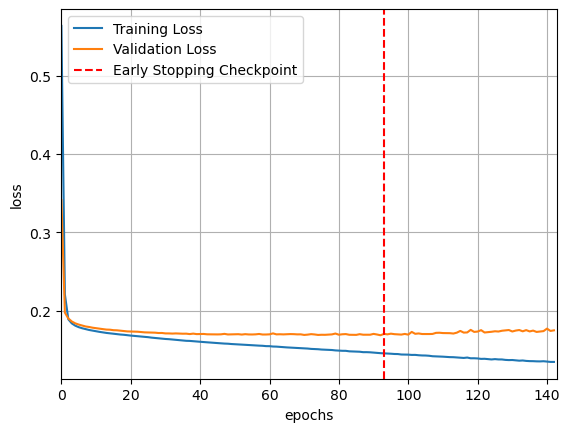

In [ ]:
plt.plot(range(len(train_losses)),train_losses, label='Training Loss')
plt.plot(range(len(valid_losses)),valid_losses,label='Validation Loss')
minposs = valid_losses.index(min(valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_losses)) # consistent scale
plt.grid(True)
plt.legend()
plt.show()

In [15]:
nn_pred_probs = test(model, test_loader, criterion)
average_precision_score(y_test_array, nn_pred_probs) # 0.3123840521753748

Test Loss: 0.0014


0.2530896364368004

## 4 - Batch Normalization

In the following codes, we build a fully connected neural network with batch normalization.

In the `__init__` method, `self.bn1 = nn.BatchNorm1d(64)` defines a batch normalization over a 2D input with 64 features.

In the `forward` method, `x = torch.relu(self.bn1(self.fc1(x)))` firstly do the linear transformation, then apply batch normalization, and then do nonlinear activation.

In [ ]:
class FNN_bn(nn.Module):
    """
    A fully connnected neural network with batch normalization
    """
    def __init__(self):
        super(FNN_bn, self).__init__()
        self.fc1 = nn.Linear(24, 64)
        self.bn1 = nn.BatchNorm1d(64) # defines batch normalization over a 2D input with 64 features
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32) # defines batch normalization over a 2D input with 32 features
        self.fc3 = nn.Linear(32, 8)
        self.bn3 = nn.BatchNorm1d(8) # defines batch normalization over a 2D input with 8 features
        self.fc4 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))
        return x

In [ ]:
model_bn = FNN_bn()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_bn.parameters(), lr=3e-4)
train(model_bn, train_loader, criterion, optimizer, num_epochs=500)

In [ ]:
nn_bn_pred_probs = test(model_bn, test_loader, criterion)
average_precision_score(y_test_array, nn_bn_pred_probs)